#**CREDIT RISK LOAN PREDICTION**

ID/X Partners Data Scientist Virtual Internship Program <br>Sultan Farel Syah Reza

**1. Data Preparation**

In [1]:
# import python library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/loan_data_2007_2014.csv")

train_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [4]:
train_df.drop(columns='Unnamed: 0',inplace=True)

2. Feature Engineering

In [5]:
# melakukan pengecekan variabel yang dijadikan target

train_df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

tujuan dari pengerjaan projek ini ialah untuk memprediksi siapa saja yang dapat diberikan pinjaman dan tidak. Berikut label-label yang dapat dikategorikan Good Debt dan Bad Debt.

bad debt :

*   Charged off
*   Late (31-120 days)
*   Late (16-30 days)
*   Does not meet the credit policy. Status:Charged Off
*   Does not meet the credit policy. Status:Fully Paid

good debt:

*   In Grace Period
*   Fully Paid
*   Current
*   Default


In [6]:
badloan = train_df.copy()

In [7]:
# membuat target feature
badloan['target'] = np.where((badloan['loan_status'] =='Charged Off') | 
                         (badloan['loan_status'] =='Does not meet the credit policy. Status:Fully Paid') |
                         (badloan['loan_status'] =='Late (31-120 days)') | 
                         (badloan['loan_status'] =='Late (16-30 days)') | 
                         (badloan['loan_status'] =='Does not meet the credit policy. Status:Charged Off'),1,0)

In [8]:
dfg = badloan.groupby('target').agg({'id':'count'}).reset_index()
dfg.columns = ['target','total']
dfg['%'] = round(dfg['total']*100/sum(dfg['total']),3)
dfg

,target,total,%
0,0,412943,88.56
1,1,53342,11.44


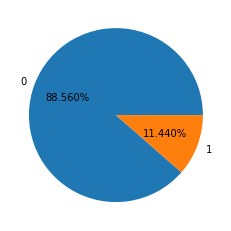

In [9]:
plt.pie(dfg['total'],labels=dfg['target'], autopct='%.3f%%')
plt.show()

Pada pie chart diatas menunjukkan bahwa persentase good debt sebesar 88.560% dan 11.440% untuk bad debt

In [10]:
badloan.groupby('target').agg({'funded_amnt':'sum','total_pymnt':'sum'}).reset_index()

,target,funded_amnt,total_pymnt
0,0,5898598725,5.000213e+09
1,1,765453725,3.810357e+08


Perusahaan loss sebesar Rp 765,453,725 karena 11.44% peminjam tidak mampu membayar

3. Data Collection


In [11]:
to_drop = badloan.isnull().sum().sort_values()
to_drop = to_drop[to_drop == badloan.shape[0]]
to_drop = list(to_drop.index)

#check dimensi dataset
print('dimensi dataset sebelum drop = ',badloan.shape)

#drop feature yang semua isinya nilai null
badloan.drop(columns=to_drop,inplace=True)

#check dimensi dataset
print('dimensi dataset setelah drop = ',badloan.shape)

dimensi dataset sebelum drop =  (466285, 75)
dimensi dataset setelah drop =  (466285, 58)


In [12]:
# memisahkan feature numerical dengan categorical
numerics = []
categorics = []
for i in badloan.columns:
  if badloan[i].dtype == 'object':
    categorics.append(i)
  else:
    numerics.append(i)
print('jumlah = ',len(numerics))
print('num = ',numerics)
print('jumlah = ',len(categorics))
print('cat = ',categorics)

jumlah =  36
num =  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']
jumlah =  22
cat =  ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type']


In [13]:
badloan['funded_amnt'][badloan['target']==1].sum()

765453725

Drop Feature yang kurang memiliki korelasi baik numerics maupun categorics

In [14]:
badloan[categorics].describe().transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
loan_status,466285,9,Current,224226
pymnt_plan,466285,2,n,466276


Feature emp_title,url,desc,title,zip_code,addr_state,application_type bisa di drop karena memiliki nilai unik yang berlebih/kurang sehingga tidak didapatkan informasi dari feature tersebut

In [15]:
# drop feature dataset pada categorical
badloan.drop(columns=['emp_title','url','desc','title','zip_code','addr_state','application_type'],inplace=True)

In [16]:
badloan[numerics].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01
delinq_2yrs,466256.0,2.846784e-01,7.973651e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01


policy_code di drop karena hanya memiliki 1 nilai unik

In [17]:
#drop feature dataset pada numeric 
badloan.drop(columns='policy_code',inplace=True)

4. Exploratory Data Analysis

In [18]:
df = badloan.copy()

In [19]:
df.shape

(466285, 50)

In [20]:
# memisahkan feature numeric dengan categoric
numerics1 = []
categorics1 = []
for i in badloan.columns:
  if df[i].dtype == 'object':
    categorics1.append(i)
  else:
    numerics1.append(i)
print('jumlah = ',len(numerics1))
print('numerics = ',numerics1)
print('jumlah = ',len(categorics1))
print('categorics = ',categorics1)

jumlah =  35
numerics =  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']
jumlah =  15
categorics =  ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']


5. Distribution Numerical Features

In [21]:
temp = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
        'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 
        'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
        'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
        'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
        'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
        'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 
        'total_rev_hi_lim']

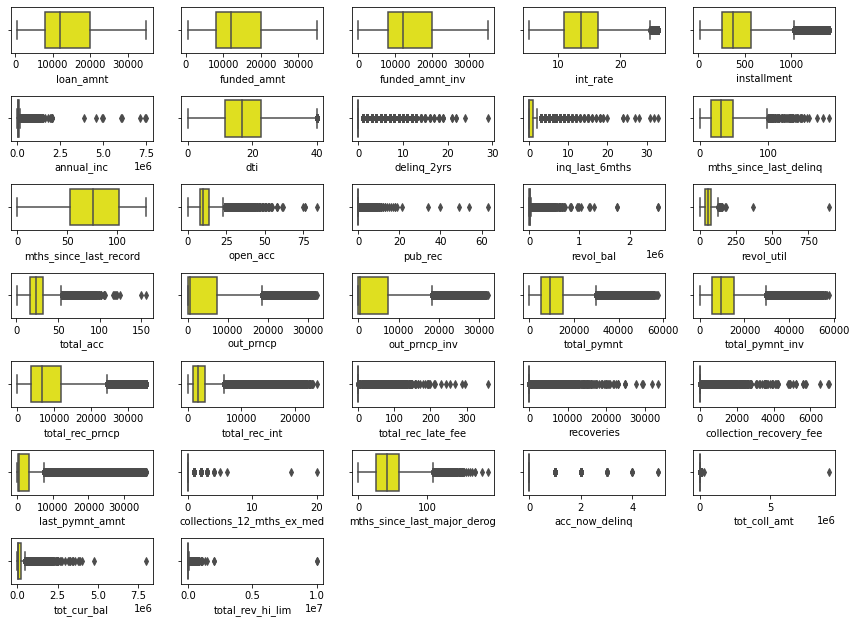

In [22]:
plt.figure(figsize=(12,12))
for i in range(0, len(temp)):
    plt.subplot(10, 5, i+1)
    sns.boxplot(x=df[temp[i]], color='yellow')
    plt.xlabel(temp[i])
    plt.tight_layout()

6. Insight

In [23]:
a = df[df['target']==1][['loan_amnt','funded_amnt','term','int_rate','installment',
                       'out_prncp','out_prncp_inv','total_pymnt',
                       'total_pymnt_inv','total_rec_prncp','total_rec_int',
                       'total_rec_late_fee','recoveries','collection_recovery_fee']]
a['must_payment'] = np.where(a['term']=='60 months',a['installment']*60,a['installment']*36)

In [24]:
#sisa yang harus dibayar oleh peminjam
a['dif'] = a['must_payment'] - (a['total_pymnt']+a['total_rec_late_fee']+a['collection_recovery_fee'])
a.head(3)

,loan_amnt,funded_amnt,term,int_rate,installment,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,must_payment,dif
1,2500,2500,60 months,15.27,59.83,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.11,2153.88,1144.06
8,5600,5600,60 months,21.28,152.39,0.0,0.0,646.02,646.02,162.02,294.94,0.0,189.06,2.09,5486.04,4837.93
9,5375,5375,60 months,12.69,121.45,0.0,0.0,1476.19,1469.34,673.48,533.42,0.0,269.29,2.52,4372.20,2893.49


In [25]:
round(sum(a.dif),5)

453018310.83504

In [26]:
a.shape

(53342, 16)

Feature dif merupakan selisih dari must_payment (jumlah yang harus dibayar oleh peminjam) dan total_pymnt. Perusahaan berpotensi rugi sebesar Rp 453,018,310.83504 karena terdapat 53342 peminjam yang buruk (tidak mampu membayar/tidak memenuhi credit policy dan sebagainya)

fitur yang saya gunakan untuk melakukan pengecekan peminjam yang gagal bayar berdasarkan grade dan purposenya yaitu Rata - rata total dari rec prncp (pinjaman pokok yang diterima sampai sekarang)



## Mean Rec prncp

In [27]:
trp = df.groupby(['target','purpose']).agg({'total_rec_prncp':'mean'}).reset_index().sort_values(['total_rec_prncp'],ascending=False)
trp.columns = ['target','purpose','avg_total_rec_prncp']
trp

,target,purpose,avg_total_rec_prncp
5,0,house,12045.509339
11,0,small_business,11383.544270
2,0,debt_consolidation,9912.608592
13,0,wedding,9720.719747
1,0,credit_card,9619.221247
4,0,home_improvement,9382.805472
10,0,renewable_energy,7927.861695
6,0,major_purchase,7463.739142
9,0,other,6652.482647
3,0,educational,6522.118699


In [28]:
trp2 = df.groupby(['target','grade','purpose']).agg({'total_rec_prncp':'mean'}).reset_index()
trp2.columns = ['target','grade','purpose','avg_total_rec_prncp']
trp2[trp2['target']==1].sort_values(['avg_total_rec_prncp'],ascending=False)

,target,grade,purpose,avg_total_rec_prncp
183,1,G,credit_card,6521.422533
123,1,B,small_business,5502.865447
103,1,A,house,5416.196316
102,1,A,home_improvement,5237.309457
99,1,A,credit_card,5164.198202
...,...,...,...,...
162,1,E,moving,1930.586991
180,1,F,vacation,1844.624667
176,1,F,moving,1655.512778
182,1,G,car,1494.111250


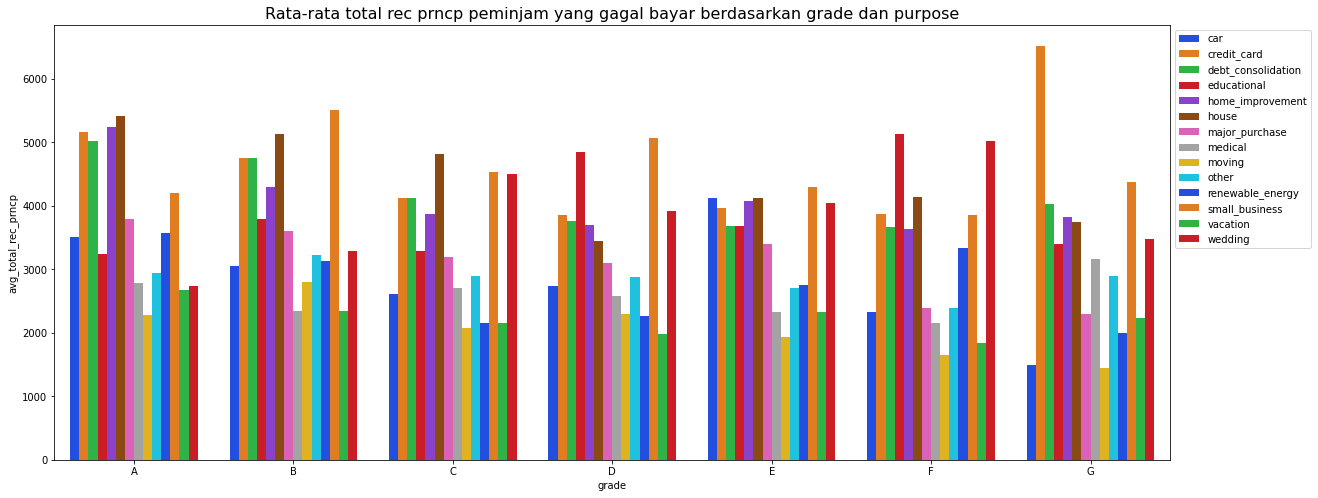

In [29]:
plt.figure(figsize=(20,8))
sns.barplot(x='grade',y='avg_total_rec_prncp',hue='purpose',data=trp2[trp2['target']==1],palette='bright')
plt.title('Rata-rata total rec prncp peminjam yang gagal bayar berdasarkan grade dan purpose',fontsize=16)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Dapat dilihat dari plot bar diatas dimana peminjam yang gagal bayar menggunakan fitur rata rata total rec prncp berdasarkan grade dan purpose tertinggi berasal dari grade G dengan tujuan peminjaman credit card. Kedua dari Grade B dengan tujuan peminjaman small_business dan yang ketiga berasal dari grade A dengan tujuan peminjaman rumah. Oleh karena itu, dapat diambil keputusan bahwa pihak bank dapat mempertimbangkan untuk menolak peminjam yang berasal dari ketiga grade dengan tujuan peminjaman tersebut.

7. Cleaning and Pre processing data

In [31]:
df = train_df.copy()

In [32]:
df.shape

(466285, 74)

Check Missing Value

In [34]:
#check persentase missing values untuk setiap feature
nv = df.isnull().sum().sort_values(ascending=False).reset_index()
nv.columns = ['feature','null']
nv['%'] = round(nv['null']*100/(df.shape[0]),3)
nv = nv[nv['%']>0]
nv

,feature,null,%
0,inq_last_12m,466285,100.000
1,verification_status_joint,466285,100.000
2,open_acc_6m,466285,100.000
3,open_il_6m,466285,100.000
4,open_il_12m,466285,100.000
5,open_il_24m,466285,100.000
6,mths_since_rcnt_il,466285,100.000
7,dti_joint,466285,100.000
8,total_bal_il,466285,100.000
9,annual_inc_joint,466285,100.000


In [35]:
#filter feature yang punya null values > 40%
nv1 = list(nv['feature'][nv['%']>40])
print(nv1)
#filter feature yang null values < 40%
nv2 = list(nv['feature'][nv['%']<40])
print(nv2)

['inq_last_12m', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'dti_joint', 'total_bal_il', 'annual_inc_joint', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'mths_since_last_record', 'mths_since_last_major_derog', 'desc', 'mths_since_last_delinq', 'next_pymnt_d']
['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'emp_title', 'emp_length', 'last_pymnt_d', 'revol_util', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'open_acc', 'pub_rec', 'total_acc', 'inq_last_6mths', 'earliest_cr_line', 'delinq_2yrs', 'acc_now_delinq', 'title', 'annual_inc']


In [36]:
# drop feature yang punya null values >40%
df.drop(columns=nv1,inplace=True)

In [38]:
temp1 = []
temp2 = []
for i in nv2:
  if (df[i].dtype == 'object') or (df[i].dtype =='category'):
    temp2.append(i)
  else:
    temp1.append(i)

In [39]:
#check statistical summary from feature on list nv2
df[temp1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tot_coll_amt,396009.0,191.913517,14630.214605,0.0,0.0,0.0,0.0,9152545.0
tot_cur_bal,396009.0,138801.713385,152114.663494,0.0,28618.0,81539.0,208953.0,8000078.0
total_rev_hi_lim,396009.0,30379.087771,37247.129571,0.0,13500.0,22800.0,37900.0,9999999.0
revol_util,465945.0,56.176947,23.732628,0.0,39.2,57.6,74.7,892.3
collections_12_mths_ex_med,466140.0,0.009085,0.108648,0.0,0.0,0.0,0.0,20.0
open_acc,466256.0,11.187069,4.987526,0.0,8.0,10.0,14.0,84.0
pub_rec,466256.0,0.160564,0.510863,0.0,0.0,0.0,0.0,63.0
total_acc,466256.0,25.064430,11.600141,1.0,17.0,23.0,32.0,156.0
inq_last_6mths,466256.0,0.804745,1.091598,0.0,0.0,0.0,1.0,33.0
delinq_2yrs,466256.0,0.284678,0.797365,0.0,0.0,0.0,0.0,29.0


In [41]:
#imputation
for i in temp1:
  df[i].fillna(df[i].median(),inplace=True)

In [42]:
#check null values
df[temp1].isnull().sum()

tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
revol_util                    0
collections_12_mths_ex_med    0
open_acc                      0
pub_rec                       0
total_acc                     0
inq_last_6mths                0
delinq_2yrs                   0
acc_now_delinq                0
annual_inc                    0
dtype: int64

In [43]:
df[temp2].describe().transpose()

,count,unique,top,freq
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
last_pymnt_d,465909,98,Jan-16,179620
last_credit_pull_d,466243,103,Jan-16,327699
earliest_cr_line,466256,664,Oct-00,3674
title,466265,63099,Debt consolidation,164075


In [49]:
df['emp_length'] = df['emp_length'].fillna('10+ years')
df['last_pymnt_d'] = df['last_pymnt_d'].fillna('Jan-16')
df['last_pymnt_d_month'] = df['last_pymnt_d'].fillna('Jan')
df['last_pymnt_d_year'] = df['last_pymnt_d'].fillna('2016')
df['last_credit_pull_d'] = df['last_credit_pull_d'].fillna('Jan-16')
df['last_credit_pull_d'] = df['last_credit_pull_d'].fillna('Jan')
df['last_credit_pull_d'] = df['last_credit_pull_d'].fillna('2016')
df['earliest_cr_line'] = df['earliest_cr_line'].fillna('Oct-00')
df['earliest_cr_line'] = df['earliest_cr_line'].fillna('Oct')
df['earliest_cr_line'] = df['earliest_cr_line'].fillna('2000')

TypeError: ignored

In [56]:
df[temp2].drop('emp_title', axis="columns")

,emp_length,last_pymnt_d,last_credit_pull_d,earliest_cr_line,title
0,10+ years,Jan-15,Jan-16,Jan-85,Computer
1,< 1 year,Apr-13,Sep-13,Apr-99,bike
2,10+ years,Jun-14,Jan-16,Nov-01,real estate business
3,10+ years,Jan-15,Jan-15,Feb-96,personel
4,1 year,Jan-16,Jan-16,Jan-96,Personal
...,...,...,...,...,...
466280,4 years,Jan-16,Jan-16,Apr-03,Debt consolidation
466281,10+ years,Dec-14,Jan-16,Jun-97,Debt consolidation
466282,7 years,Jan-16,Dec-15,Dec-01,Debt consolidation
466283,3 years,Dec-14,Apr-15,Feb-03,Credit card refinancing


In [57]:
df[temp2].drop('title', axis="columns")

,emp_title,emp_length,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,NaN,10+ years,Jan-15,Jan-16,Jan-85
1,Ryder,< 1 year,Apr-13,Sep-13,Apr-99
2,NaN,10+ years,Jun-14,Jan-16,Nov-01
3,AIR RESOURCES BOARD,10+ years,Jan-15,Jan-15,Feb-96
4,University Medical Group,1 year,Jan-16,Jan-16,Jan-96
...,...,...,...,...,...
466280,Financial Advisor,4 years,Jan-16,Jan-16,Apr-03
466281,Chief of Interpretation (Park Ranger),10+ years,Dec-14,Jan-16,Jun-97
466282,patrol,7 years,Jan-16,Dec-15,Dec-01
466283,Server Engineer Lead,3 years,Dec-14,Apr-15,Feb-03


In [61]:
df.duplicated().any()

False

Preprocessing

In [62]:
df.shape

(466285, 54)

In [63]:
df[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].head()

,issue_d,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,Dec-11,Jan-15,Jan-16,Jan-85
1,Dec-11,Apr-13,Sep-13,Apr-99
2,Dec-11,Jun-14,Jan-16,Nov-01
3,Dec-11,Jan-15,Jan-15,Feb-96
4,Dec-11,Jan-16,Jan-16,Jan-96


In [65]:
df[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   issue_d             466285 non-null  object
 1   last_pymnt_d        466285 non-null  object
 2   last_credit_pull_d  466285 non-null  object
 3   earliest_cr_line    466285 non-null  object
dtypes: object(4)
memory usage: 14.2+ MB


In [66]:
from datetime import datetime as dt
df['issue_d'] = pd.to_datetime(df['issue_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'].apply(lambda x: dt.strptime(x, '%b-%y')))

In [67]:
df[['last_pymnt_d','last_credit_pull_d','earliest_cr_line']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   last_pymnt_d        466285 non-null  datetime64[ns]
 1   last_credit_pull_d  466285 non-null  datetime64[ns]
 2   earliest_cr_line    466285 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 10.7 MB


In [68]:
df[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].head()

,issue_d,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,2011-12-01,2015-01-01,2016-01-01,1985-01-01
1,2011-12-01,2013-04-01,2013-09-01,1999-04-01
2,2011-12-01,2014-06-01,2016-01-01,2001-11-01
3,2011-12-01,2015-01-01,2015-01-01,1996-02-01
4,2011-12-01,2016-01-01,2016-01-01,1996-01-01


In [69]:
df['period'] = (df['last_credit_pull_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + (df['last_credit_pull_d'].dt.month - df['earliest_cr_line'].dt.month)
df['period'].head()

0    372
1    173
2    170
3    227
4    240
Name: period, dtype: int64

In [70]:
nums2 = []
cats2 = []

for i in df.columns:
  if (df[i].dtype == 'object') or (df[i].dtype == 'category'):
    cats2.append(i)
  else:
    nums2.append(i)

In [71]:
print(len(cats2))
print(cats2)

18
['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status', 'application_type', 'last_pymnt_d_month', 'last_pymnt_d_year']


In [73]:
df.pymnt_plan.value_counts()

n    466276
y         9
Name: pymnt_plan, dtype: int64

In [74]:
temp = ['term', 'grade','emp_length', 'home_ownership','verification_status','purpose','initial_list_status', 
        'issue_d_month', 'issue_d_year', 
        'earliest_cr_line_month', 'earliest_cr_line_year', 
        'last_pymnt_d_month', 'last_pymnt_d_year',
        'last_credit_pull_d_month', 'last_credit_pull_d_year']

In [75]:
len(temp)

15

KeyError: ignored

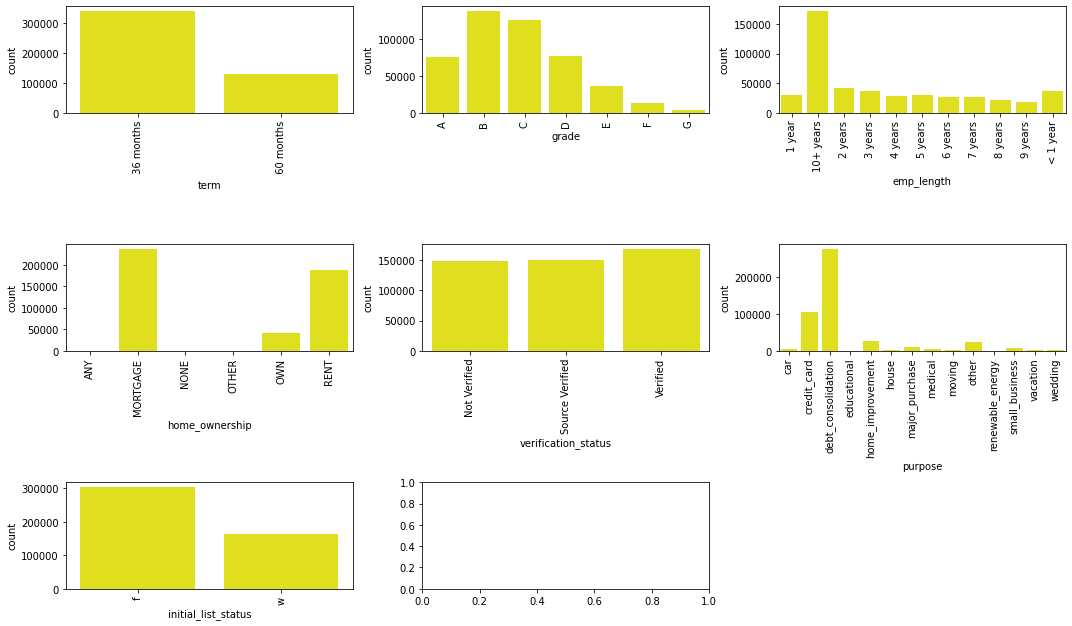

In [76]:
plt.figure(figsize=(15,15))
for i in range(0, len(temp)):
    plt.subplot(5, 3, i+1)
    sns.countplot(x=df[temp[i]].sort_values(), color='yellow')
    plt.xlabel(temp[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [77]:
df.home_ownership.replace({'NONE':'OTHER','ANY':'OTHER','OWN':'OTHER'},inplace=True)
df.home_ownership.unique()

array(['RENT', 'OTHER', 'MORTGAGE'], dtype=object)

In [83]:
def year(x):
  if int( x['earliest_cr_line']) >= 2000:
    result = '00s'
  else:
    if int( x['earliest_cr_line']) >= 1990:
      result = '90s'
    elif int( x['earliest_cr_line']) >= 1980:
      result = '80s'
    elif int( x['earliest_cr_line']) >= 1970:
      result = '70s'
    elif int( x['earliest_cr_line']) >= 1960:
      result = '60s'
    else:
      result = '50s'
  return result

In [97]:
temp1 = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status']

In [98]:
df_encode = df.copy()

In [99]:
df_encode[temp1].describe().transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
emp_length,466285,11,10+ years,171057
home_ownership,466285,3,MORTGAGE,235875
verification_status,466285,3,Verified,168055
purpose,466285,14,debt_consolidation,274195
initial_list_status,466285,2,f,303005


In [116]:
df_encode.term.replace({'36 months':0,'60 months':1},inplace=True)
df_encode.grade.replace({'G':0,'F':1,'E':2,'D':3,'C':4,'B':5,'A':6},inplace=True)
df_encode.emp_length.replace({'< 1 year':0, '1 year':1, '2 years':2,
                                           '3 years':3, '4 years':4, '5 years':5,
                                           '6 years':6, '7 years':7, '8 years':8, 
                                           '9 years':9, '10+ years':10},inplace=True)
df_encode.initial_list_status.replace({'w':0,'f':1},inplace=True)

In [120]:
label_encode = ['term','grade','emp_length','initial_list_status']

In [160]:
# Separate ordinal and nominal object
features_nominal = ['pymnt_plan','home_ownership','purpose','initial_list_status']
features_ordinal = ['grade','sub_grade','emp_length','verification_status']

In [166]:
# Label encoding for ordinal features

ordinal_LE = {'grade' : {'A' : 7, 'B' : 6, 'C' : 5, 'D' : 4, 'E' : 3, 'F' : 2, 'G' : 1},
              'sub_grade' : {'A1' : 35, 'A2' : 34, 'A3' : 33, 'A4' : 32, 'A5': 31,
                            'B1' : 30, 'B2' : 29, 'B3' : 28, 'B4' : 27, 'B5': 26,
                            'C1' : 25, 'C2' : 24, 'C3' : 23, 'C4' : 22, 'C5': 21,
                            'D1' : 20, 'D2' : 19, 'D3' : 18, 'D4' : 17, 'D5': 16,
                            'E1' : 15, 'E2' : 14, 'E3' : 13, 'E4' : 12, 'E5': 11,
                            'F1' : 10, 'F2' : 9, 'F3' : 8, 'F4' : 7, 'F5': 6,
                            'G1' : 5, 'G2' : 4, 'G3' : 3, 'G4' : 2, 'G5': 1,},
              'emp_length' : {'10+ years' : 11, '9 years' : 10, '8 years' : 9, '7 years' : 8,
                             '6 years' : 7, '5 years' : 6, '4 years' : 5, '3 years' : 4,
                             '2 years' : 3, '1 year' : 2, '< 1 year' : 1},
              'verification_status' : {'Verified' : 3, 'Source Verified' : 2, 'Not Verified' : 1}}

df_encode = df_encode.replace(ordinal_LE)

In [124]:
df_encode.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'last_pymnt_d_month', 'last_pymnt_d_year', 'period',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownersh